In [ ]:
#libraries import

import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
import random
import matplotlib.image as mpimg


In [ ]:
# specifying the path

train_path = 'Face Mask Dataset/Train'
test_path = 'Face Mask Dataset/Test'
val_path = 'Face Mask Dataset/Validation'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Data augmentation define
datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   zoom_range=0.25, 
                                   horizontal_flip=True, 
                                   samplewise_center=True, 
                                   samplewise_std_normalization=True,
                                   fill_mode='nearest')


# applying it on train, test and val folder
train = datagen.flow_from_directory(train_path,target_size=(256,256), class_mode='categorical',batch_size=200)
val = datagen.flow_from_directory(val_path,target_size=(256,256), class_mode='categorical',batch_size=64)


test_datagen = ImageDataGenerator(rescale=1./255)

test= test_datagen.flow_from_directory(
    test_path,
    target_size=(256,256),
    batch_size=64,
    color_mode='rgb',
    shuffle=False,    
    class_mode=None)

Found 10002 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


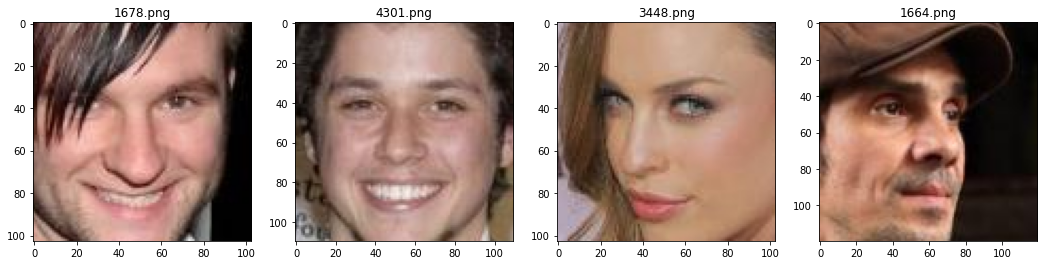

In [ ]:
# plotting the image withoud mask
plt.figure(figsize=(18,18))
img_folder='Face Mask Dataset/Train/WithoutMask/'
for m in range(4):
    img_location = random.choice(os.listdir(img_folder))
    loc= os.path.join(img_folder, img_location)
    image=mpimg.imread(loc)
    ax=plt.subplot(1,4,m+1)
    ax.title.set_text(img_location)
    plt.imshow(image)

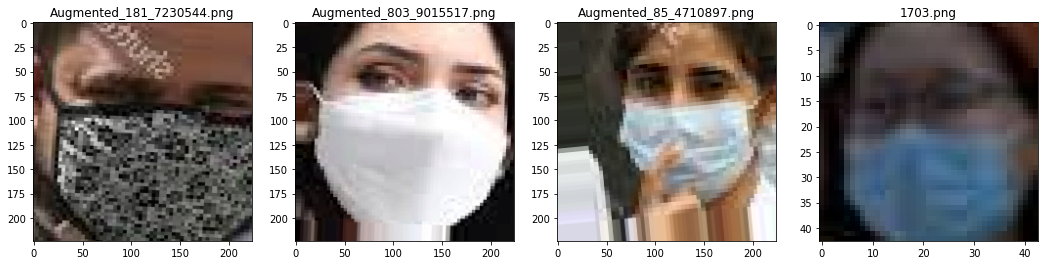

In [ ]:
# plotting the image with mask
plt.figure(figsize=(18,18))
img_folder='Face Mask Dataset/Train/WithMask/'

for m in range(4):
    img_location = random.choice(os.listdir(img_folder))
    loc= os.path.join(img_folder, img_location)
    image=mpimg.imread(loc)
    ax1=plt.subplot(1,4,m+1)
    ax1.title.set_text(img_location)
    plt.imshow(image)

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import DenseNet201

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models, layers


# ResNet101V2

In [ ]:
# resnet block is called
resnet = ResNet101V2(weights='imagenet',include_top=False,input_shape=(256,256,3))

# setting the traiable to false
resnet.trainable = False 

#adding the ouput
m=resnet.output
m=GlobalAveragePooling2D()(m)

# fully connectd layer
m=Dense(128,activation='relu')(m) 

# output layer
res=Dense(2,activation='softmax')(m)

model=models.Model(inputs=resnet.input,outputs=res)

# model summary
model.summary()

171327488/171317808 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
# model compile
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


# specifying the train, test and val size
train_size=train.n//train.batch_size
val_size  =val.n//val.batch_size
test_size =test.n//test.batch_size

In [ ]:
# running the model
history = model.fit(train,steps_per_epoch=train_size,epochs=10,
                    validation_data=val, validation_steps=val_size)

Epoch 1/10
50/50 [==============================] - 1578s 31s/step - loss: 0.3256 - accuracy: 0.8847 - val_loss: 0.0863 - val_accuracy: 0.9714
Epoch 2/10
50/50 [==============================] - 159s 3s/step - loss: 0.0681 - accuracy: 0.9747 - val_loss: 0.0498 - val_accuracy: 0.9792
Epoch 3/10
50/50 [==============================] - 159s 3s/step - loss: 0.0532 - accuracy: 0.9829 - val_loss: 0.0592 - val_accuracy: 0.9779
Epoch 4/10
50/50 [==============================] - 159s 3s/step - loss: 0.0435 - accuracy: 0.9850 - val_loss: 0.0385 - val_accuracy: 0.9870
Epoch 5/10
50/50 [==============================] - 159s 3s/step - loss: 0.0394 - accuracy: 0.9850 - val_loss: 0.0436 - val_accuracy: 0.9844
Epoch 6/10
50/50 [==============================] - 159s 3s/step - loss: 0.0358 - accuracy: 0.9869 - val_loss: 0.0321 - val_accuracy: 0.9909
Epoch 7/10
50/50 [==============================] - 159s 3s/step - loss: 0.0365 - accuracy: 0.9873 - val_loss: 0.0505 - val_accuracy: 0.9766
Epoch 8/10


In [ ]:
# saving it
model.save('densenet.h5')

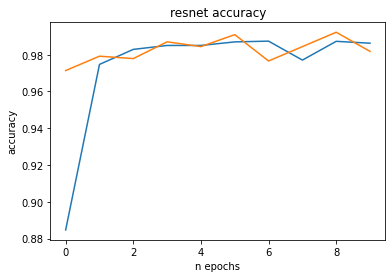

In [ ]:
#plotting the accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('resnet accuracy')
plt.ylabel('accuracy')
plt.xlabel('n epochs')
plt.show()

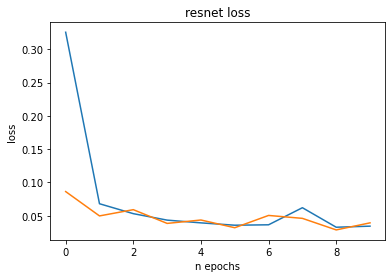

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('resnet loss')
plt.ylabel('loss')
plt.xlabel('n epochs')
plt.show()

In [ ]:
# making prediction on test set
resnet_pred=model.predict(test) 
y_pred = np.argmax(resnet_pred,axis=1)
y_actual = test.classes

In [ ]:
from sklearn.metrics import classification_report as cr
print(cr(y_actual, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       483
           1       1.00      0.99      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



## Resnet with ml

In [ ]:
# extracting feature using ResNet
attributes=model.predict(train)
att = attributes.reshape(attributes.shape[0], -1)


In [ ]:
from sklearn.linear_model import LogisticRegression as LR
# logistic regression
clf = LR()
clf.fit(att,train.labels)

LogisticRegression()

In [ ]:
atts = model.predict(test)
atts = atts.reshape(atts.shape[0], -1)

pred=clf.predict(atts)
print(cr(test.labels, pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       483
           1       1.00      0.99      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



# VGG19

In [ ]:
train = datagen.flow_from_directory(train_path,target_size=(224,224), class_mode='categorical',batch_size=200)
val = datagen.flow_from_directory(val_path,target_size=(224,224), class_mode='categorical',batch_size=64)

test_datagen = ImageDataGenerator(rescale=1./255)

test= test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=64,
    color_mode='rgb',
    shuffle=False,    
    class_mode=None)

Found 10002 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [ ]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(224,224,3))
vgg19.trainable = False 

m=vgg19.output
m=GlobalAveragePooling2D()(m)
m=Dense(128,activation='relu')(m) 
res=Dense(2,activation='softmax')(m)

model=models.Model(inputs=vgg19.input,outputs=res)

model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
# running the model
history = model.fit(train,steps_per_epoch=train_size,epochs=10,
                    validation_data=val, validation_steps=val_size)

Epoch 1/10
50/50 [==============================] - 136s 3s/step - loss: 0.2531 - accuracy: 0.9099 - val_loss: 0.1205 - val_accuracy: 0.9661
Epoch 2/10
50/50 [==============================] - 131s 3s/step - loss: 0.0895 - accuracy: 0.9746 - val_loss: 0.0674 - val_accuracy: 0.9818
Epoch 3/10
50/50 [==============================] - 128s 3s/step - loss: 0.0585 - accuracy: 0.9834 - val_loss: 0.0693 - val_accuracy: 0.9779
Epoch 4/10
50/50 [==============================] - 128s 3s/step - loss: 0.0505 - accuracy: 0.9850 - val_loss: 0.0500 - val_accuracy: 0.9844
Epoch 5/10
50/50 [==============================] - 128s 3s/step - loss: 0.0417 - accuracy: 0.9881 - val_loss: 0.0393 - val_accuracy: 0.9883
Epoch 6/10
50/50 [==============================] - 128s 3s/step - loss: 0.0342 - accuracy: 0.9892 - val_loss: 0.0301 - val_accuracy: 0.9883
Epoch 7/10
50/50 [==============================] - 128s 3s/step - loss: 0.0345 - accuracy: 0.9892 - val_loss: 0.0311 - val_accuracy: 0.9922
Epoch 8/10
50

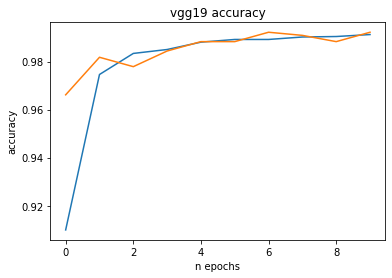

In [ ]:
# plotting the loss and accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('vgg19 accuracy')
plt.ylabel('accuracy')
plt.xlabel('n epochs')
plt.show()

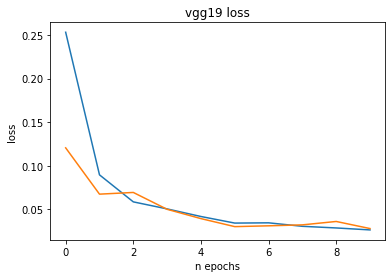

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('vgg19 loss')
plt.ylabel('loss')
plt.xlabel('n epochs')
plt.show()

In [ ]:
# making prediction 
vgg19_pred=model.predict(test) 
y_pred = np.argmax(vgg19_pred,axis=1)
y_actual = test.classes

In [ ]:
from sklearn.metrics import classification_report as cr
print(cr(y_actual, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       483
           1       0.95      0.90      0.93       509

    accuracy                           0.93       992
   macro avg       0.93      0.93      0.93       992
weighted avg       0.93      0.93      0.93       992



## VGG19 with ml

In [ ]:
attributes=model.predict(train)
att = attributes.reshape(attributes.shape[0], -1)


In [ ]:
from sklearn.linear_model import LogisticRegression as LR
clf = LR()
clf.fit(att,train.labels)

LogisticRegression()

In [ ]:
atts = model.predict(test)
atts = atts.reshape(atts.shape[0], -1)

pred=clf.predict(atts)
print(cr(test.labels, pred))

              precision    recall  f1-score   support

           0       0.79      0.98      0.88       483
           1       0.98      0.75      0.85       509

    accuracy                           0.87       992
   macro avg       0.89      0.87      0.86       992
weighted avg       0.89      0.87      0.86       992



In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC

# random forest classifier

clf = RFC()
clf.fit(att,train.labels)

RandomForestClassifier()

In [ ]:
atts = model.predict(test)
atts = atts.reshape(atts.shape[0], -1)

pred=clf.predict(atts)
print(cr(test.labels, pred))

              precision    recall  f1-score   support

           0       0.48      0.51      0.50       483
           1       0.51      0.49      0.50       509

    accuracy                           0.50       992
   macro avg       0.50      0.50      0.50       992
weighted avg       0.50      0.50      0.50       992



# VGG16

In [ ]:
# loading the pretrained model
vgg16 = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

vgg16.trainable = False 

m=vgg16.output
m=GlobalAveragePooling2D()(m)
m=Dense(128,activation='relu')(m) 
res=Dense(2,activation='softmax')(m)

model=models.Model(inputs=vgg16.input,outputs=res)

model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(train,steps_per_epoch=train_size,epochs=10,
                    validation_data=val, validation_steps=val_size)

Epoch 1/10
50/50 [==============================] - 129s 3s/step - loss: 0.0254 - accuracy: 0.9910 - val_loss: 0.0183 - val_accuracy: 0.9935
Epoch 2/10
50/50 [==============================] - 127s 3s/step - loss: 0.0216 - accuracy: 0.9928 - val_loss: 0.0142 - val_accuracy: 0.9974
Epoch 3/10
50/50 [==============================] - 127s 3s/step - loss: 0.0190 - accuracy: 0.9939 - val_loss: 0.0122 - val_accuracy: 0.9961
Epoch 4/10
50/50 [==============================] - 127s 3s/step - loss: 0.0188 - accuracy: 0.9946 - val_loss: 0.0133 - val_accuracy: 0.9948
Epoch 5/10
50/50 [==============================] - 127s 3s/step - loss: 0.0172 - accuracy: 0.9950 - val_loss: 0.0121 - val_accuracy: 0.9961
Epoch 6/10
50/50 [==============================] - 128s 3s/step - loss: 0.0174 - accuracy: 0.9945 - val_loss: 0.0165 - val_accuracy: 0.9935
Epoch 7/10
50/50 [==============================] - 128s 3s/step - loss: 0.0186 - accuracy: 0.9950 - val_loss: 0.0186 - val_accuracy: 0.9948
Epoch 8/10
50

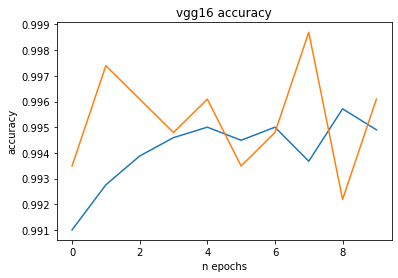

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('vgg16 accuracy')
plt.ylabel('accuracy')
plt.xlabel('n epochs')
plt.show()

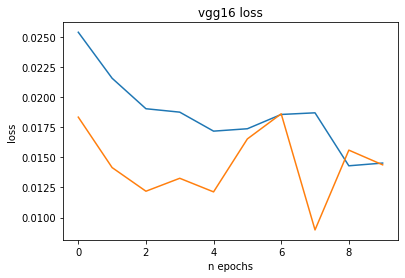

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('vgg16 loss')
plt.ylabel('loss')
plt.xlabel('n epochs')
plt.show()

In [ ]:
vgg16_pred=model.predict(test) 
y_pred = np.argmax(vgg16_pred,axis=1)
y_actual = test.classes

In [ ]:
from sklearn.metrics import classification_report as cr
print(cr(y_actual, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       483
           1       0.95      0.96      0.95       509

    accuracy                           0.95       992
   macro avg       0.95      0.95      0.95       992
weighted avg       0.95      0.95      0.95       992



## VGG16 with ml

In [ ]:
attributes=model.predict(train)
att = attributes.reshape(attributes.shape[0], -1)


In [ ]:
from sklearn.linear_model import LogisticRegression as LR
clf = LR()
clf.fit(att,train.labels)

LogisticRegression()

In [ ]:
atts = model.predict(test)
atts = atts.reshape(atts.shape[0], -1)

pred=clf.predict(atts)
print(cr(test.labels, pred))

              precision    recall  f1-score   support

           0       0.49      1.00      0.65       483
           1       0.00      0.00      0.00       509

    accuracy                           0.49       992
   macro avg       0.24      0.50      0.33       992
weighted avg       0.24      0.49      0.32       992



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
clf = RFC()
clf.fit(att,train.labels)

RandomForestClassifier()

In [ ]:
atts = model.predict(test)
atts = atts.reshape(atts.shape[0], -1)

pred=clf.predict(atts)
print(cr(test.labels, pred))

              precision    recall  f1-score   support

           0       0.52      0.53      0.53       483
           1       0.55      0.54      0.55       509

    accuracy                           0.54       992
   macro avg       0.54      0.54      0.54       992
weighted avg       0.54      0.54      0.54       992



# MobileNetV2

In [ ]:
# loading the pretrained model

mobilenet = MobileNetV2(weights = "imagenet",include_top = False,input_shape=(224,224,3))


mobilenet.trainable = False 

m=mobilenet.output
m=GlobalAveragePooling2D()(m)
m=Dense(128,activation='relu')(m) 
res=Dense(2,activation='softmax')(m)

model=models.Model(inputs=mobilenet.input,outputs=res)

model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                             

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(train,steps_per_epoch=train_size,epochs=10,
                    validation_data=val, validation_steps=val_size)

Epoch 1/10
50/50 [==============================] - 127s 2s/step - loss: 0.0372 - accuracy: 0.9877 - val_loss: 0.0185 - val_accuracy: 0.9948
Epoch 2/10
50/50 [==============================] - 124s 2s/step - loss: 0.0253 - accuracy: 0.9909 - val_loss: 0.0239 - val_accuracy: 0.9909
Epoch 3/10
50/50 [==============================] - 124s 2s/step - loss: 0.0237 - accuracy: 0.9932 - val_loss: 0.0200 - val_accuracy: 0.9935
Epoch 4/10
50/50 [==============================] - 124s 2s/step - loss: 0.0216 - accuracy: 0.9923 - val_loss: 0.0219 - val_accuracy: 0.9922
Epoch 5/10
50/50 [==============================] - 125s 3s/step - loss: 0.0242 - accuracy: 0.9920 - val_loss: 0.0148 - val_accuracy: 0.9948
Epoch 6/10
50/50 [==============================] - 127s 3s/step - loss: 0.0269 - accuracy: 0.9907 - val_loss: 0.0163 - val_accuracy: 0.9948
Epoch 7/10
50/50 [==============================] - 125s 3s/step - loss: 0.0169 - accuracy: 0.9944 - val_loss: 0.0223 - val_accuracy: 0.9935
Epoch 8/10
50

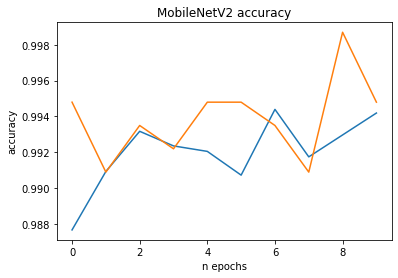

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MobileNetV2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('n epochs')
plt.show()

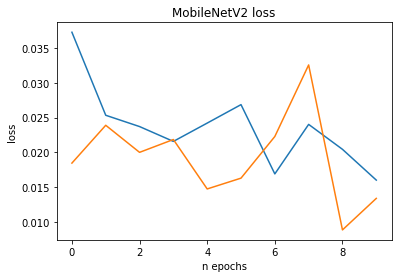

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MobileNetV2 loss')
plt.ylabel('loss')
plt.xlabel('n epochs')
plt.show()

In [ ]:
MobileNetV2_pred=model.predict(test) 
y_pred = np.argmax(MobileNetV2_pred,axis=1)
y_actual = test.classes

In [ ]:
from sklearn.metrics import classification_report as cr
print(cr(y_actual, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       483
           1       0.95      0.98      0.97       509

    accuracy                           0.96       992
   macro avg       0.96      0.96      0.96       992
weighted avg       0.96      0.96      0.96       992



## MobileNetv2 with ml

In [ ]:
attributes=model.predict(train)
att = attributes.reshape(attributes.shape[0], -1)


In [ ]:
from sklearn.linear_model import LogisticRegression as LR
clf = LR()
clf.fit(att,train.labels)

LogisticRegression()

In [ ]:
atts = model.predict(test)
atts = atts.reshape(atts.shape[0], -1)

pred=clf.predict(atts)
print(cr(test.labels, pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       483
           1       0.95      0.98      0.97       509

    accuracy                           0.96       992
   macro avg       0.97      0.96      0.96       992
weighted avg       0.97      0.96      0.96       992



In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
clf = RFC()
clf.fit(att,train.labels)

RandomForestClassifier()

In [ ]:
atts = model.predict(test)
atts = atts.reshape(atts.shape[0], -1)

pred=clf.predict(atts)
print(cr(test.labels, pred))

              precision    recall  f1-score   support

           0       0.49      0.70      0.58       483
           1       0.53      0.32      0.40       509

    accuracy                           0.51       992
   macro avg       0.51      0.51      0.49       992
weighted avg       0.51      0.51      0.49       992



# DenseNet201

In [ ]:
# loading the pretrained model

densenet = DenseNet201(weights = "imagenet",include_top = False,input_shape=(256,256,3))

densenet.trainable = False 

m=densenet.output
m=GlobalAveragePooling2D()(m)
m=Dense(128,activation='relu')(m) 
res=Dense(2,activation='softmax')(m)

model=models.Model(inputs=densenet.input,outputs=res)

model.summary()



74850304/74836368 [==============================] - 0s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_5[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                           

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(train,steps_per_epoch=train_size,epochs=10,
                    validation_data=val, validation_steps=val_size)

Epoch 1/10
50/50 [==============================] - 188s 3s/step - loss: 0.0568 - accuracy: 0.9757 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 2/10
50/50 [==============================] - 127s 3s/step - loss: 0.0114 - accuracy: 0.9964 - val_loss: 0.0090 - val_accuracy: 0.9961
Epoch 3/10
50/50 [==============================] - 127s 3s/step - loss: 0.0106 - accuracy: 0.9969 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 4/10
50/50 [==============================] - 127s 3s/step - loss: 0.0085 - accuracy: 0.9969 - val_loss: 0.0076 - val_accuracy: 0.9987
Epoch 5/10
50/50 [==============================] - 127s 3s/step - loss: 0.0067 - accuracy: 0.9981 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 6/10
50/50 [==============================] - 127s 3s/step - loss: 0.0080 - accuracy: 0.9976 - val_loss: 0.0054 - val_accuracy: 0.9974
Epoch 7/10
50/50 [==============================] - 127s 3s/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.0041 - val_accuracy: 0.9987
Epoch 8/10
50

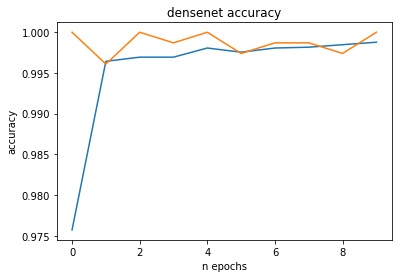

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('densenet accuracy')
plt.ylabel('accuracy')
plt.xlabel('n epochs')
plt.show()

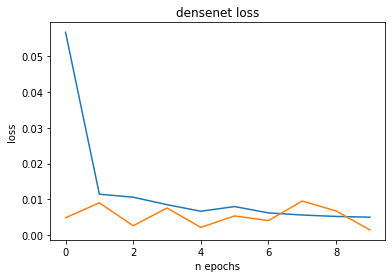

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('densenet loss')
plt.ylabel('loss')
plt.xlabel('n epochs')
plt.show()

In [ ]:
densenet_pred=model.predict(test) 
y_pred = np.argmax(densenet_pred,axis=1)
y_actual = test.classes

In [ ]:
from sklearn.metrics import classification_report as cr
print(cr(y_actual, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       483
           1       1.00      0.99      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



## DenseNet201 with ml

In [ ]:
attributes=model.predict(train)
att = attributes.reshape(attributes.shape[0], -1)


In [ ]:
from sklearn.linear_model import LogisticRegression as LR
clf = LR()
clf.fit(att,train.labels)

LogisticRegression()

In [ ]:
atts = model.predict(test)
atts = atts.reshape(atts.shape[0], -1)

pred=clf.predict(atts)
print(cr(test.labels, pred))

              precision    recall  f1-score   support

           0       0.01      0.01      0.01       483
           1       0.00      0.00      0.00       509

    accuracy                           0.01       992
   macro avg       0.01      0.01      0.01       992
weighted avg       0.01      0.01      0.01       992



In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
clf = RFC()
clf.fit(att,train.labels)

RandomForestClassifier()

In [ ]:
atts = model.predict(test)
atts = atts.reshape(atts.shape[0], -1)

pred=clf.predict(atts)
print(cr(test.labels, pred))

              precision    recall  f1-score   support

           0       0.25      0.30      0.27       483
           1       0.19      0.16      0.17       509

    accuracy                           0.23       992
   macro avg       0.22      0.23      0.22       992
weighted avg       0.22      0.23      0.22       992

